In [80]:
from importlib import reload
from load_cluster_data import load_cluster_data
import gc

import numpy as np
import torch
import pandas as pd 
import seaborn as sns
import collections

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

float_type = { 
    "device" : device, 
    "dtype" : torch.float, # save memory
}

hypers = {
    "eta" : 1., 
    "alpha_prior" : 1., # karin had 0.65 
    "pi_prior" : 1.
}

K = 10

import plotnine as p9
import scipy.sparse as sp
import matplotlib.pyplot as plt 
import splicing_PCA_utils
from nuclear_norm_PCA import sparse_sum

from pca_kmeans_init import pca_kmeans_init
from betabinomo_LDA_singlecells_kinit import *
import betabinomo_LDA_singlecells_kinit
reload(betabinomo_LDA_singlecells_kinit)


cuda


<module 'betabinomo_LDA_singlecells_kinit' from '/gpfs/commons/home/kisaev/leafcutter-sc/src/beta-binomial-lda/betabinomo_LDA_singlecells_kinit.py'>

### Load data

In [62]:
input_file = '/gpfs/commons/groups/knowles_lab/Karin/parse-pbmc-leafcutter/leafcutter/junctions/PBMC_input_for_LDA.h5'
final_data, coo_counts_sparse, coo_cluster_sparse, cell_ids_conversion, junction_ids_conversion = load_cluster_data(
    input_file) # , celltypes = ["B", "MemoryCD4T"])

# still do preprocessing in scipy
indices = (final_data.cell_id_index, final_data.junction_id_index)
indices_np = np.stack(indices)
junc_counts = sp.coo_matrix((final_data.junc_count, indices))
cluster_counts = sp.coo_matrix((final_data.cluster_count, indices))

['B' 'CD14Mono' 'CD8T' 'DC' 'FCGR3A' 'IGHA' 'MemoryCD4T' 'NK' 'NaiveCD4T'
 'ZNF385D']


also printing original indices of junctions we are keeping


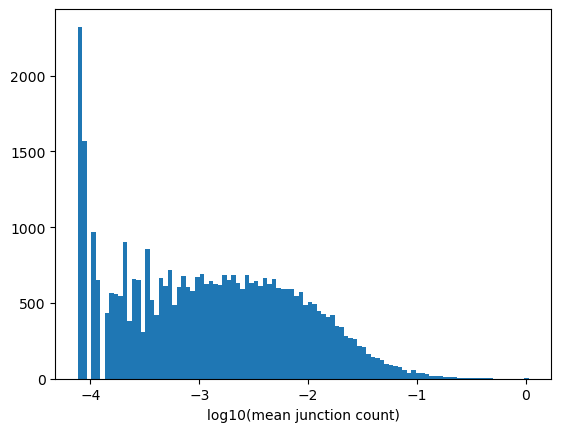

In [63]:
junc_counts_sub, cluster_counts_sub, to_keep = splicing_PCA_utils.filter_junctions(
    junc_counts, cluster_counts, plot = True)

junc_ind_keep = junction_ids_conversion["junction_id_index"][to_keep]
final_data = final_data[final_data.junction_id_index.isin(junc_ind_keep)]

In [64]:
junction_ids_conversion=junction_ids_conversion[to_keep]
junction_ids_conversion["new_junction_id_index"] = np.arange(junction_ids_conversion.shape[0])

In [65]:
# re-order the remaining junctions 
final_data = final_data.merge(junction_ids_conversion, on = "junction_id_index")
final_data

,cell_id_index,junction_id_index,junc_count,cluster_count,clustminjunc,juncratio,cell_id,cell_type,junction_id,Cluster,new_junction_id_index
0,0,2527,1.0,1,0.0,1.0,B_10_10_3,B,11_60466157_60466958,6402,720
1,3,2527,3.0,5,2.0,0.6,B_10_10_66,B,11_60466157_60466958,6402,720
2,12,2527,3.0,5,2.0,0.6,B_10_13_51,B,11_60466157_60466958,6402,720
3,20,2527,1.0,1,0.0,1.0,B_10_14_90,B,11_60466157_60466958,6402,720
4,21,2527,3.0,3,0.0,1.0,B_10_15_42,B,11_60466157_60466958,6402,720
...,...,...,...,...,...,...,...,...,...,...,...
22020670,65310,36552,2.0,2,0.0,1.0,NaiveCD4T_9_62_78,NaiveCD4T,9_33443458_33443765,5720,9483
22020671,65358,36552,1.0,1,0.0,1.0,NaiveCD4T_9_81_94,NaiveCD4T,9_33443458_33443765,5720,9483
22020672,30803,36552,0.0,2,2.0,0.0,MemoryCD4T_13_12_1,MemoryCD4T,9_33443458_33443765,5720,9483
22020673,38644,36552,0.0,1,1.0,0.0,MemoryCD4T_43_59_10,MemoryCD4T,9_33443458_33443765,5720,9483


In [66]:
print(junc_counts_sub.toarray()[3, 720]) # should be 3 sanity check of data 
print(cluster_counts_sub.toarray()[3, 720]) # should be 5 sanity check of data 

3.0
5


### Simulate Data

In [67]:
sim_junc_counts = splicing_PCA_utils.simulate_junc_counts(
    cluster_counts_sub,
    cell_ids_conversion.cell_type.astype('category')
)

In [68]:
# make dataframe using the following columsn 
sim_junc_counts_flat = pd.DataFrame({"cell_id_index": sim_junc_counts.row, "new_junction_id_index": sim_junc_counts.col, "new_junc_count": sim_junc_counts.data})

# update junction counts in final_data object to be the simulated counts 
final_data = final_data.merge(sim_junc_counts_flat, on = ["cell_id_index", "new_junction_id_index"])

### Prep simulated data as input into LDA 

In [76]:
sim_data = final_data.copy() # make a copy of the data
sim_data.drop(columns = ["junc_count", "junction_id_index"], inplace = True) # drop the old junction counts and junction id index
# rename columns new_junction_id_index and new_junc_count to junction_id_index and junc_count
sim_data.rename(columns = {"new_junction_id_index": "junction_id_index", "new_junc_count": "junc_count"}, inplace = True)

In [78]:
my_data = make_torch_data(sim_data, **float_type)

In [79]:
my_data

IndexCountTensor(junc_index=tensor([ 720,  720,  720,  ..., 9483, 9483, 9483], device='cuda:0'), cell_index=tensor([    0,     3,    12,  ..., 30803, 38644, 38694], device='cuda:0'), y_count=tensor([0., 1., 2.,  ..., 2., 1., 1.], device='cuda:0'), t_count=tensor([0., 2., 2.,  ..., 2., 1., 1.], device='cuda:0'), cells_lookup=tensor(crow_indices=tensor([       0,      247,      476,  ..., 22019932,
                            22020201, 22020675]),
       col_indices=tensor([       0,     5682,    12502,  ..., 21622479,
                           21690254, 21862481]),
       values=tensor([1., 1., 1.,  ..., 1., 1., 1.]), device='cuda:0',
       size=(65457, 22020675), nnz=22020675, layout=torch.sparse_csr), ycount_lookup=tensor(crow_indices=tensor([       0,      732,     1464,  ..., 22019027,
                            22019851, 22020675]),
       col_indices=tensor([12135022, 12135023, 12135024,  ..., 13947072,
                           13947073, 13947074]),
       values=tensor([1., 

### Run LDA

10
Initialize VI params
Got the initial ELBO
ELBO converged, CAVI iteration #  300  complete
                   0         1         2         3         4         5  \
cell_id                                                                  
B           0.015737  0.566442  0.019281  0.307365  0.016243  0.014604   
CD14Mono    0.013001  0.012310  0.015736  0.013336  0.879759  0.012928   
CD8T        0.871191  0.013320  0.017124  0.014719  0.015123  0.013454   
DC          0.010042  0.008807  0.914548  0.009428  0.009484  0.009365   
FCGR3A      0.011926  0.010678  0.015089  0.011934  0.012247  0.011753   
IGHA        0.020709  0.020015  0.763881  0.026228  0.056473  0.017569   
MemoryCD4T  0.012057  0.010881  0.015210  0.012116  0.012466  0.558906   
NK          0.013997  0.012738  0.018653  0.014415  0.015178  0.013374   
NaiveCD4T   0.011299  0.010313  0.014941  0.011233  0.012328  0.011117   
ZNF385D     0.076283  0.038511  0.226225  0.112668  0.163281  0.034218   

                  

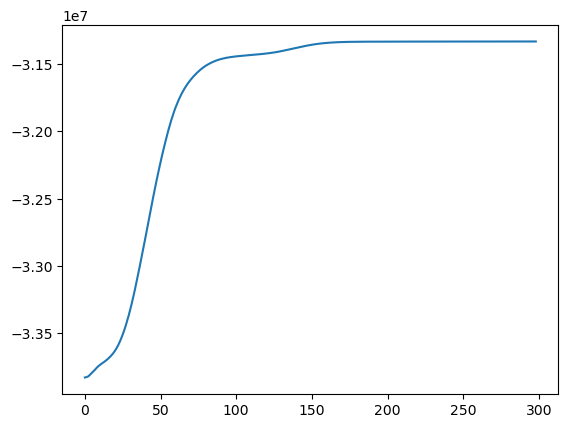

In [81]:
num_trials = 1 # can't currently run more than 1 or overflow GPU memory :( 
num_iters = 300 # should also be an argument that gets fed in

# loop over the number of trials (for now just testing using one trial but in general need to evaluate how performance is affected by number of trials)
for t in range(num_trials):

    # run coordinate ascent VI
    print(K)

    ALPHA_f, PI_f, GAMMA_f, PHI_f, elbos_all = calculate_CAVI(K, my_data, float_type, hypers = hypers, num_iterations = num_iters)
    elbos_all = np.array(elbos_all)
    juncs_probs = ALPHA_f / (ALPHA_f+PI_f)
    
    theta_f = GAMMA_f / GAMMA_f.sum(1,keepdim=True)
    theta_f_plot = pd.DataFrame(theta_f.cpu())
    theta_f_plot['cell_id'] = cell_ids_conversion["cell_type"].to_numpy()
    theta_f_plot_summ = theta_f_plot.groupby('cell_id').mean()
    print(theta_f_plot_summ)
    
    # plot ELBO
    plt.plot(elbos_all[2:]); plt.show()

col_0,0,1,2,3,4,5,6,7,8,9
cell_type,,,,,,,,,,
B,0,9950,0,3328,0,0,0,0,0,0
CD14Mono,0,0,0,0,2254,0,0,0,0,0
CD8T,7132,0,0,0,0,0,0,0,0,0
DC,0,0,1093,0,0,0,0,0,0,0
FCGR3A,0,0,0,0,0,0,5628,0,0,0
IGHA,0,0,497,0,0,0,0,0,0,0
MemoryCD4T,0,0,1,0,0,8354,0,0,3471,0
NK,0,0,0,0,0,0,0,14973,0,0
NaiveCD4T,0,0,0,0,0,0,0,0,0,8703


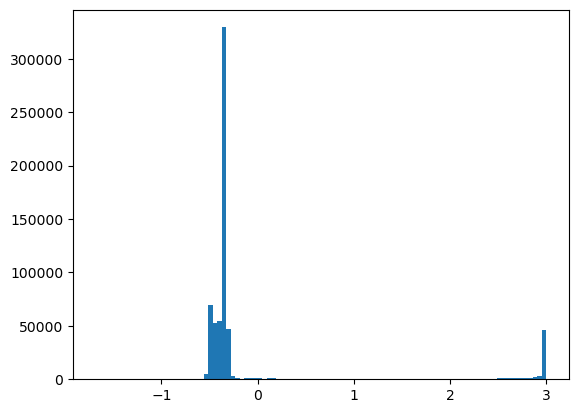

In [82]:
x = theta_f.cpu().numpy()
x -= x.mean(1,keepdims=True)
x /= x.std(1,keepdims=True)
plt.hist(x.flatten(),100)
pd.crosstab( cell_ids_conversion["cell_type"], x.argmax(axis=1) )

In [125]:
x

array([[-0.40955123,  2.9076807 , -0.39592195, ..., -0.42046124,
        -0.42485264, -0.4263044 ],
       [-0.41892636,  0.27578887, -0.3815572 , ..., -0.4275332 ,
        -0.3989707 , -0.41440457],
       [-0.50501585,  1.8994327 , -0.48550645, ..., -0.51370937,
        -0.4983929 , -0.4960781 ],
       ...,
       [ 1.4021796 , -1.0295442 ,  0.53604937, ..., -0.86133236,
         0.5772705 , -0.73727596],
       [-0.61933386, -0.12394034,  2.787068  , ..., -0.8676102 ,
        -0.3118857 , -0.39704826],
       [-0.34752017, -0.96008974,  1.1933388 , ..., -0.7588806 ,
         0.38729095, -1.1271183 ]], dtype=float32)

In [126]:
x.shape

(65457, 10)

In [127]:
labels=cell_ids_conversion["cell_type"].to_numpy()

In [129]:
xdf=pd.DataFrame(x)

In [151]:
from sklearn.decomposition import PCA
pca_dat = PCA(n_components=10)
principalComponents_breast = pca_dat.fit_transform(xdf)

In [153]:
principal_x_Df = pd.DataFrame(data = principalComponents_breast
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5', 'pc6', 'pc7', 'pc8', 'pc9', 'pc10'])
print('Explained variation per principal component: {}'.format(pca_dat.explained_variance_ratio_))


Explained variation per principal component: [2.4643955e-01 2.0688486e-01 1.6702491e-01 1.3491717e-01 1.0576622e-01
 4.6060119e-02 3.2705341e-02 3.0564688e-02 2.9637102e-02 5.9185061e-12]


In [154]:
principal_x_Df['cell_type'] = labels
principal_x_Df

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,cell_type
0,-1.627376,-2.231420,-0.823614,-0.360467,-0.206461,-0.179496,-0.833237,0.147262,-0.098335,0.000024,B
1,-1.158951,-1.409781,-0.463868,-0.164012,-0.019449,0.226404,2.540442,-0.525822,0.372290,0.000034,B
2,-1.634428,-2.236871,-0.801225,-0.365039,-0.201689,-0.050393,1.070562,-0.291403,0.191749,0.000008,B
3,-1.645375,-2.254065,-0.837950,-0.381771,-0.217760,-0.192711,-0.709171,0.109441,-0.063896,0.000012,B
4,-1.622270,-2.207252,-0.815184,-0.361208,-0.215477,-0.184287,-0.897122,0.180083,-0.105322,0.000027,B
...,...,...,...,...,...,...,...,...,...,...,...
65452,-0.555753,0.417138,0.671240,1.437236,0.205208,2.036934,1.295755,2.138360,-0.125137,0.000007,ZNF385D
65453,0.688917,0.749862,0.033830,0.916105,0.523111,2.778887,0.216132,1.475100,0.703623,0.000007,ZNF385D
65454,-0.565172,0.115690,0.703516,2.029637,-0.290995,2.318483,1.012009,0.835816,0.918145,0.000008,ZNF385D
65455,-0.825858,-0.313052,0.239395,0.084540,0.359955,1.866870,1.089968,2.134345,-1.633243,0.000008,ZNF385D


/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Axes: xlabel='pc1', ylabel='pc2'>

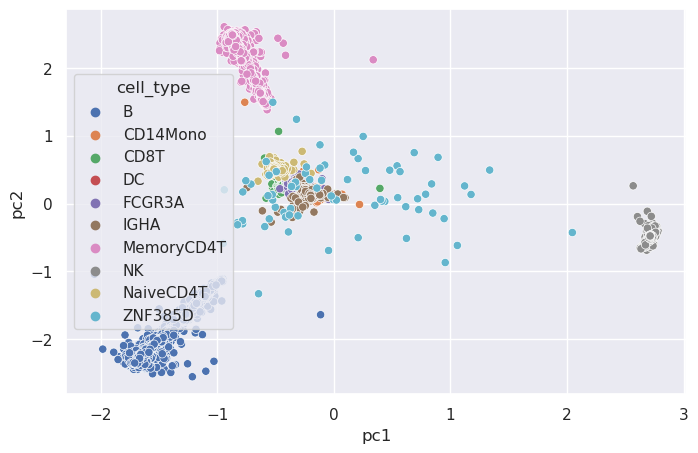

In [155]:
sns.scatterplot("pc1", "pc2", data=principal_x_Df, hue = "cell_type")

/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Axes: xlabel='pc2', ylabel='pc3'>

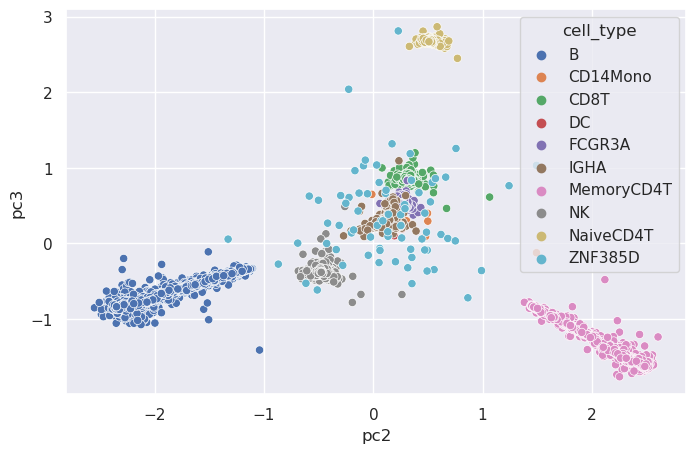

In [156]:
sns.scatterplot("pc2", "pc3", data=principal_x_Df, hue = "cell_type")

/gpfs/commons/home/kisaev/.local/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.


<Axes: xlabel='pc1', ylabel='pc3'>

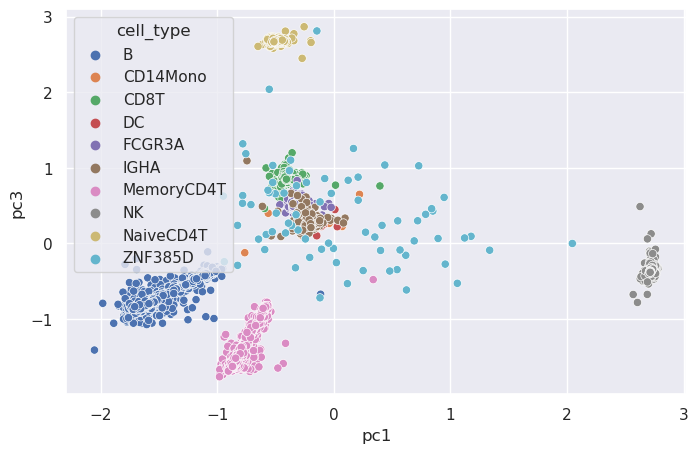

In [157]:
sns.scatterplot("pc1", "pc3", data=principal_x_Df, hue = "cell_type")